In [13]:
%pip install mosaicml
%pip install tensorflow
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to u

In [5]:
!pip install torchcontrib
!pip install torchsummary

In [14]:
from numpy.random import seed
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import torch
import torchvision
import torch.nn.functional as F

from composer.models import ComposerModel
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision import transforms, datasets

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import time
import torchmetrics

import torch.optim as optim
from composer import Trainer
import composer
from composer.algorithms import BlurPool
from composer.loggers import InMemoryLogger

import matplotlib.pyplot as plt
import numpy as np


import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision.transforms.functional import InterpolationMode

from torchvision.models.inception import InceptionOutputs
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


In [15]:
base_dir='./data/ham10000'

In [93]:
def create_folder_struct():
    
    train_dir = os.path.join(base_dir, 'Train')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'Test')
    os.mkdir(val_dir)

    # [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    nv = os.path.join(train_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(train_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(train_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(train_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(train_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(train_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(train_dir, 'df')
    os.mkdir(df)



    # create new folders inside val_dir
    nv = os.path.join(val_dir, 'nv')
    os.mkdir(nv)
    mel = os.path.join(val_dir, 'mel')
    os.mkdir(mel)
    bkl = os.path.join(val_dir, 'bkl')
    os.mkdir(bkl)
    bcc = os.path.join(val_dir, 'bcc')
    os.mkdir(bcc)
    akiec = os.path.join(val_dir, 'akiec')
    os.mkdir(akiec)
    vasc = os.path.join(val_dir, 'vasc')
    os.mkdir(vasc)
    df = os.path.join(val_dir, 'df')
    os.mkdir(df)

In [94]:
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Test')

In [95]:
create_folder_struct()

In [96]:
df_data=pd.read_csv(base_dir+'/HAM10000_metadata')

In [97]:
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [98]:
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head(100)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000001,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
95,HAM_0000132,1,1,1,1,1,1,1
96,HAM_0000133,1,1,1,1,1,1,1
97,HAM_0000134,1,1,1,1,1,1,1
98,HAM_0000137,1,1,1,1,1,1,1


In [99]:
def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates


In [100]:
df_data

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,has_duplicates


In [101]:
df_data['duplicates'].value_counts()


no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [102]:
#in df we store dataset with no duplicates
df=df_data[df_data['duplicates'] == 'no_duplicates']

df.shape


(5514, 9)

We have 5514 unique skin lesion image


In [103]:
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,vidir_modern,no_duplicates
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,vidir_modern,no_duplicates
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,vidir_modern,no_duplicates
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,vidir_modern,no_duplicates
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,rosendahl,no_duplicates


In [104]:
y= df["dx"]

_, df_val = train_test_split(df, test_size=0.2, random_state=101, stratify=y)

df_val.shape

(1103, 9)

**dx** column uniquely identifies the class of each Image,

In [105]:
df_val['dx'].value_counts()


nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

In [106]:
#Helper Function to uniquely identify and remove validation dataset from original dataset where duplicates existed

def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


In [107]:
# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


8912
1103


In [108]:
#value count the class in train dataset
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [109]:
part1=os.listdir(base_dir+'/HAM10000_images_part_1')
part2= os.listdir(base_dir+'/HAM10000_images_part_2')

In [110]:
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

In [111]:
df_data.set_index('image_id', inplace=True)

In [112]:
def transfer_train_images():
    for image in train_list:
    
        fname = image + '.jpg'
        label = df_data.loc[image,'dx']

        if fname in part1:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_1', fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

        if fname in part2:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_2', fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

In [113]:
transfer_train_images()

In [114]:
def transfer_val_images():
    for image in val_list:
    
        fname = image + '.jpg'
        label = df_data.loc[image,'dx']

        if fname in part1:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_1', fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

        if fname in part2:
            # source path to image
            src = os.path.join(base_dir+'/HAM10000_images_part_2', fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)

In [115]:
transfer_val_images()

In [116]:
df_train['dx'].value_counts()

nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [117]:
print(len(os.listdir(base_dir+'/Test/nv')))
print(len(os.listdir(base_dir+'/Test/mel')))
print(len(os.listdir(base_dir+'/Test/bkl')))
print(len(os.listdir(base_dir+'/Test//bcc')))
print(len(os.listdir(base_dir+'/Test/akiec')))
print(len(os.listdir(base_dir+'/Test/vasc')))
print(len(os.listdir(base_dir+'/Test/df')))

883
46
88
35
30
13
8


In [118]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

There is definitely a class imbalance in the provided dataset, one way to deal with it it so augmenting the class of images 

In [119]:
data_directory=base_dir+"/Train"
dataset = ImageFolder(root=data_directory)

In [120]:
dataset.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [121]:
def perform_augmentation():
    # note that we are not augmenting class 'nv'
    class_list = ['mel','bkl','bcc','akiec','vasc','df']

    for item in class_list:

        # We are creating temporary directories here because we delete these directories later
        # create a base dir
        aug_dir = 'aug_dir'
        os.mkdir(aug_dir)
        # create a dir within the base dir to store images of the same class
        img_dir = os.path.join(aug_dir, 'img_dir')
        os.mkdir(img_dir)

        # Choose a class
        img_class = item

        # list all images in that directory
        img_list = os.listdir(base_dir+'/Train/' + img_class)

        # Copy images from the class train dir to the img_dir e.g. class 'mel'
        for fname in img_list:
            # source path to image
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                src = os.path.join(base_dir+'/Train/' + img_class, fname)
                # destination path to image
                dst = os.path.join(img_dir, fname)
                # copy the image from the source to the destination
                shutil.copyfile(src, dst)


        # point to a dir containing the images and not to the images themselves
        path = aug_dir
        save_path = base_dir+'/Train/'  + img_class

        # Create a data generator
        datagen = ImageDataGenerator(
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            #brightness_range=(0.9,1.1),
            fill_mode='nearest')

        batch_size = 50

        aug_datagen = datagen.flow_from_directory(path,
                                               save_to_dir=save_path,
                                               save_format='jpg',
                                                        target_size=(300,400),
                                                        batch_size=batch_size)



        # Generate the augmented images and add them to the training folders

        ###########

        num_aug_images_wanted = 6000 # total number of images we want to have in each class

        ###########

        num_files = len(os.listdir(img_dir))
        num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

        # run the generator and create about 6000 augmented images
        for i in range(0,num_batches):

            imgs, labels = next(aug_datagen)

        # delete temporary directory with the raw image files
        shutil.rmtree('aug_dir')

In [122]:
perform_augmentation()

Found 1067 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 129 images belonging to 1 classes.
Found 107 images belonging to 1 classes.


In [123]:
# check how many train images we have in each folder

print('nv ------>', len(os.listdir(base_dir+'/Train/nv')))
print('mel ----->', len(os.listdir(base_dir+'/Train/mel')))
print('bkl ----->', len(os.listdir(base_dir+'/Train/bkl')))
print('bcc ----->', len(os.listdir(base_dir+'/Train//bcc')))
print('akiec --->', len(os.listdir(base_dir+'/Train/akiec')))
print('vasc ---->', len(os.listdir(base_dir+'/Train/vasc')))
print('df ------>', len(os.listdir(base_dir+'/Train/df')))

nv ------> 5822
mel -----> 5885
bkl -----> 5855
bcc -----> 5798
akiec ---> 5990
vasc ----> 5210
df ------> 4330


In [124]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
# plots(imgs, titles=None) # titles=labels will display the image labels

In [125]:
df_train

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,has_duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,has_duplicates,train
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,has_duplicates,train
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,has_duplicates,train


In [140]:
def requirementsForModelTraining(model):
    blurpool = BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool)
    )
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    algorithms=[blurpool]
    return algorithms, optimizer

In [127]:
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_of_classes=7
def evaluate_model(model):  
    model.eval()
    accuracy_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_of_classes, average='micro')
    true_labels = []
    predicted_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            # Move data to the same device as the model (CPU or GPU)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            inputs, targets = inputs.to(device), targets.to(device)

            # Perform the forward pass and get the outputs
            outputs = model(inputs)

            # Get the predicted class by finding the index with the highest score
            _, predicted = torch.max(outputs.data, 1)

            # Accumulate the true labels and predicted labels for each batch
            true_labels.extend(targets.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print the results
    accuracy = 100 * correct / total
    print(f"Accuracy on the evaluation dataset: {accuracy:.2f}%")
    print("\n")

    # Calculate precision, recall, and F1 score for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    TN = np.sum(conf_matrix) - (TP + FP + FN)

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1_score)


In [128]:
# Set your desired image size
def transform_images(image_size, crop_size=None):

    train_path=base_dir + '/Train/'
    valid_path=base_dir + '/Test/'

    # Define data transforms for training and validation datasets
    train_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    valid_transforms = transforms.Compose([
        transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets from the directories using torchvision.datasets.ImageFolder
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

    # Create data loaders
    train_batch_size = 10
    val_batch_size = 10

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)
    return train_dataloader, valid_dataloader, test_dataloader


In [129]:
def test_model(model_class, model_path, image_path, image_size):
    num_classes=7
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Replace with the input size of your model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Replace with the normalization values used during training
    ])
    image=Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image = image.to(device)
    model = model.to(device)

    with torch.no_grad():
        outputs = model(image)

    _, predicted_idx = torch.max(outputs.data, 1)
    predicted_class = class_names[predicted_idx.item()]

    print("Predicted Class:", predicted_class)


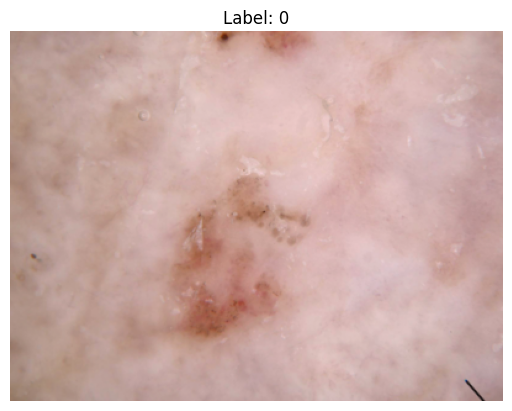

In [132]:

# Fetch one batch from the test_dataloader
_, _, test_dataloader = transform_images((300,400),(300,400))
for images, labels in test_dataloader:
    break

# Unnormalize the image data for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images.numpy().transpose((0, 2, 3, 1))
images = std * images + mean
images = np.clip(images, 0, 1)

# Display the image
plt.imshow(images[0])
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


In [141]:
logger = InMemoryLogger()
train_dataloader, valid_dataloader, test_dataloader=transform_images((300,400),(300,400))

In [143]:
class ResNet18(ComposerModel):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()

    def forward(self, batch):  # batch is the output of the dataloader
        # Determine the format of the batch and handle it accordingly
        if isinstance(batch, tuple):
            # If the batch is in the format (inputs, targets)
            inputs, targets = batch
        else:
            # If the batch is just the inputs
            inputs = batch

        return self.model(inputs)

    def loss(self, outputs, batch):
        # pass batches and `forward` outputs to the loss
        _, targets = batch
        return F.cross_entropy(outputs, targets)

In [144]:
resnetBP = ResNet18()
algorithms, optimizer=requirementsForModelTraining(resnetBP)
trainer = Trainer(
    model=resnetBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

In [ ]:
evaluate_model(resnetBP)
torch.save(resnetBP.state_dict(), './models/resnet18_BP_20ep.pth')

In [148]:
trainer.close()

Resnet Model without BlurPool

In [149]:
resnetWOBP = ResNet18()

trainer = Trainer(
    model=resnetWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

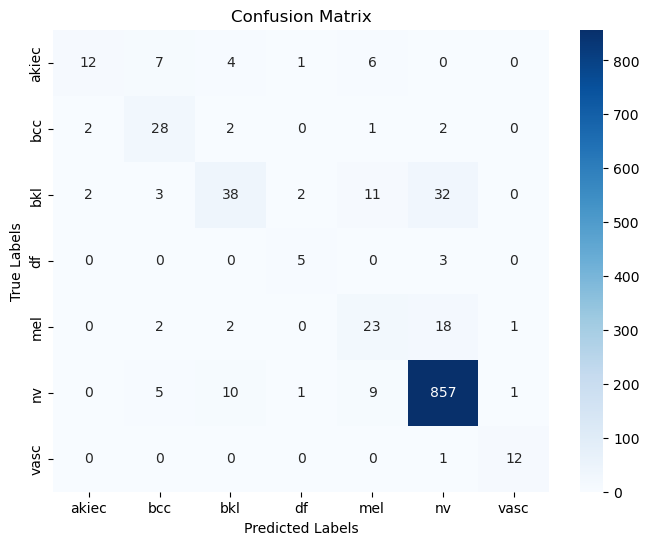

Accuracy on the evaluation dataset: 88.40%


Precision: [0.75       0.62222222 0.67857143 0.55555556 0.46       0.93866375
 0.85714286]
Recall: [0.4        0.8        0.43181818 0.625      0.5        0.97055493
 0.92307692]
F1 Score: [0.52173913 0.7        0.52777778 0.58823529 0.47916667 0.95434298
 0.88888889]


In [51]:
evaluate_model(resnetWOBP)


In [ ]:
torch.save(resnetWOBP.state_dict(), './models/resnet18_WOBP_20ep.pth')
trainer.close()

## Statistics

**ResNet18** with **BlurPool** gives an accuracy of **88.94%**

**ResNet18** without **BlurPool** gives an accuracy of **87.85%**

**Time To Train ResNet18** with BlurPool is 2124.83 seconds

**Time To Train ResNet18** without BlurPool is 2734.7752 seconds

In [ ]:
torch.cuda.empty_cache()

# EfficientNet 

In [46]:
class EfficientNetB3(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b3()
        
        # Modify the final classification head
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = torch.nn.Linear(in_features, num_classes)
        
        self.num_classes = num_classes
        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        # Print the number of classes attribute
        metric.update(outputs, targets)
        
    def _eval_train_metrics(self, device_batch):
            # Separate inputs and targets from the device_batch
            inputs, targets = device_batch

            # Set the model to evaluation mode
            self.model.eval()

            # Perform the forward pass and get the outputs
            with torch.no_grad():
                outputs = self.model(inputs)
                eval_outputs = self.eval_forward(device_batch, outputs)

            # Update the metrics with the computed outputs
            for _, metric in self.state.train_metrics.items():
                self.update_metric(device_batch, eval_outputs, metric)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [44]:
efficientBP = EfficientNetB3(num_classes=7)
algorithms, optimizer=requirementsForModelTraining(efficientBP)
trainer = Trainer(
    model=efficientBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

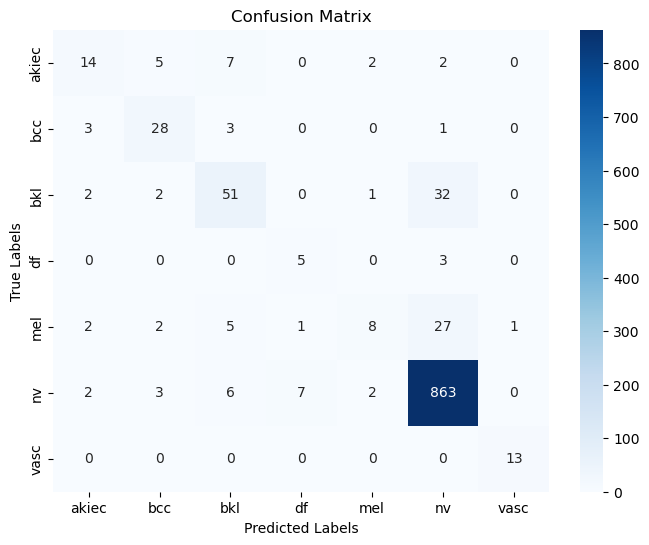

Accuracy on the evaluation dataset: 89.03%


Precision: [0.60869565 0.7        0.70833333 0.38461538 0.61538462 0.9299569
 0.92857143]
Recall: [0.46666667 0.8        0.57954545 0.625      0.17391304 0.97734994
 1.        ]
F1 Score: [0.52830189 0.74666667 0.6375     0.47619048 0.27118644 0.95306461
 0.96296296]


In [46]:
evaluate_model(efficientBP)

In [47]:
torch.save(efficientBP.state_dict(), './models/efficientBP_20ep.pth')
trainer.close()

In [ ]:
# test_model(EfficientNetB3,'./models/trained_model_efficientModel_15ep.pth',base_dir+'/Test/vasc/ISIC_0025707.jpg',224)

## Efficient Net Without Blurpool

In [48]:
efficientWOBP = EfficientNetB3(num_classes=7)
trainer = Trainer(
    model=efficientWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

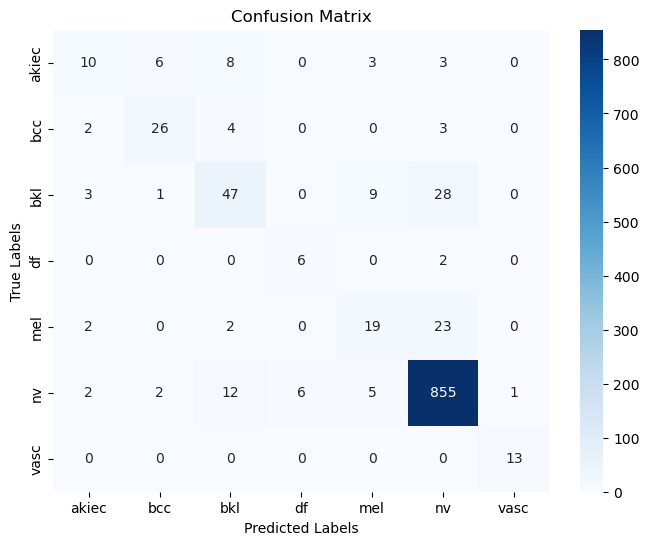

Accuracy on the evaluation dataset: 88.49%


Precision: [0.52631579 0.74285714 0.64383562 0.5        0.52777778 0.93544858
 0.92857143]
Recall: [0.33333333 0.74285714 0.53409091 0.75       0.41304348 0.96828992
 1.        ]
F1 Score: [0.40816327 0.74285714 0.58385093 0.6        0.46341463 0.95158598
 0.96296296]


In [50]:
evaluate_model(efficientWOBP)

In [ ]:
torch.save(efficientWOBP.state_dict(), './models/efficientWOBP_20ep.pth')

# MobileNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
from composer.models import ComposerModel

class MobileNetV2(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.mobilenet_v2()  # You can use pretrained weights if needed
        self.num_classes = num_classes

        # Modify the final classification head
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        metric.update(outputs, targets)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
mobileNetBP = MobileNetV2(num_classes=7)
algorithms, optimizer,  = requirementsForModelTraining(mobileNetBP)
logger = InMemoryLogger()
trainer = Trainer(
    model=mobileNetBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [45]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 4
blurpool/num_blurpool_layers: 0
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 2321244148

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 4101.7634 seconds to train


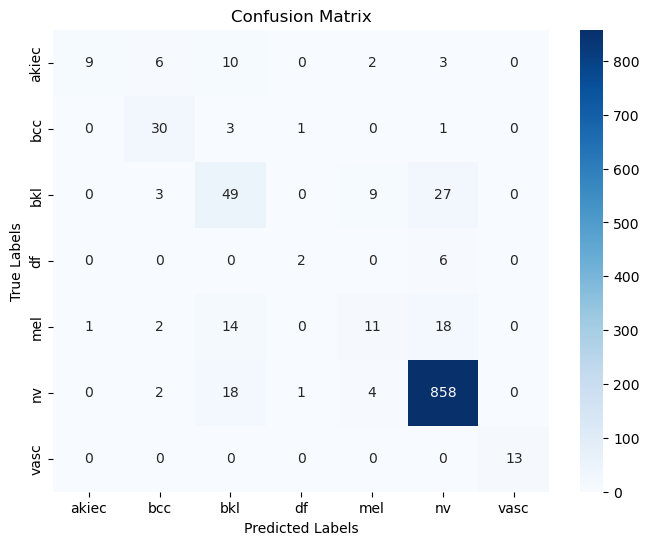

Accuracy on the evaluation dataset: 88.12%


Precision: [0.9        0.69767442 0.5212766  0.5        0.42307692 0.93975904
 1.        ]
Recall: [0.3        0.85714286 0.55681818 0.25       0.23913043 0.97168743
 1.        ]
F1 Score: [0.45       0.76923077 0.53846154 0.33333333 0.30555556 0.95545657
 1.        ]


In [46]:
evaluate_model(mobileNetBP)

In [ ]:
torch.save(mobileNetBP.state_dict(), './models/mobileNetBP_20ep.pth')
trainer.close()

# MobileNet Without BlurPool


In [46]:
mobileNetWOBP = MobileNetV2(num_classes=7)
logger = InMemoryLogger()
trainer = Trainer(
    model=mobileNetWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader,
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3777163748

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 5059.3937 seconds to train


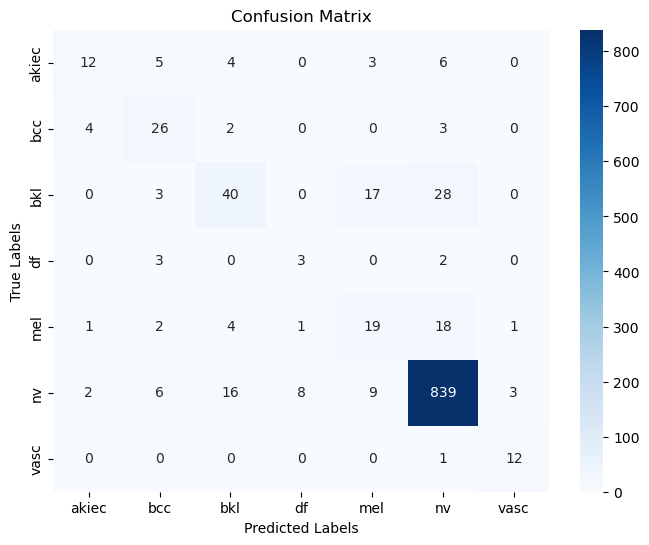

Accuracy on the evaluation dataset: 86.22%


Precision: [0.63157895 0.57777778 0.60606061 0.25       0.39583333 0.93534002
 0.75      ]
Recall: [0.4        0.74285714 0.45454545 0.375      0.41304348 0.95016988
 0.92307692]
F1 Score: [0.48979592 0.65       0.51948052 0.3        0.40425532 0.94269663
 0.82758621]


In [ ]:
evaluate_model(mobileNetWOBP)

In [ ]:
torch.save(mobileNetWOBP.state_dict(), './models/mobileNetWOBP_20ep.pth')
trainer.close()

# InceptionNet


In [60]:
# import os
# os.environ['TORCH_USE_CUDA_DSA'] = '1'
# os.environ['CUDA_LAUNCH_BLOCKING']= '1'

In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode

def transform_images_inception_net(resize_size,crop_size):
    train_path = base_dir + '/Train/'
    valid_path = base_dir + '/Test/'

    # Define data transforms for training and validation datasets
    train_transforms = Compose([
        Resize(resize_size, interpolation=InterpolationMode.BILINEAR),
        CenterCrop(crop_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    valid_transforms = Compose([
        Resize(resize_size, interpolation=InterpolationMode.BILINEAR),
        CenterCrop(crop_size),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load datasets from the directories using torchvision.datasets.ImageFolder
    train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
    valid_dataset = datasets.ImageFolder(root=valid_path, transform=valid_transforms)

    # Create data loaders
    train_batch_size = 10
    val_batch_size = 10

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=val_batch_size, shuffle=False)

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)
    return train_dataloader, valid_dataloader, test_dataloader


In [ ]:
# train_dataloader, valid_dataloader, test_dataloader=transform_images_inception_net(342,299)

In [ ]:
class InceptionNetV3(ComposerModel):
    def __init__(self, num_classes, weights=None):
        super().__init__()
        self.model = torchvision.models.inception_v3()
        self.num_classes = num_classes

        # Modify the final classification head
        in_features = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features, num_classes)

        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch

        # Extract the necessary tensor from InceptionOutputs
        logits = outputs.logits

        return F.cross_entropy(logits, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if isinstance(outputs, InceptionOutputs):
            logits = outputs.logits
        else:
            logits = self.forward(inputs)
        if logits.dim() > 1 and logits.shape[1] != self.num_classes:
            logits = torch.softmax(logits, dim=1)
        return logits

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        if isinstance(outputs, InceptionOutputs):
            outputs = outputs.logits

        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)

        metric.update(outputs, targets)


    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [ ]:
inceptionNetBP = InceptionNetV3(num_classes=7)
algorithms, optimizer = requirementsForModelTraining(inceptionNetBP)
trainer = Trainer(
    model=inceptionNetBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
******************************
Config:
blurpool/num_blurconv_layers: 4
blurpool/num_blurpool_layers: 2
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 804008059

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 8091.5614 seconds to train


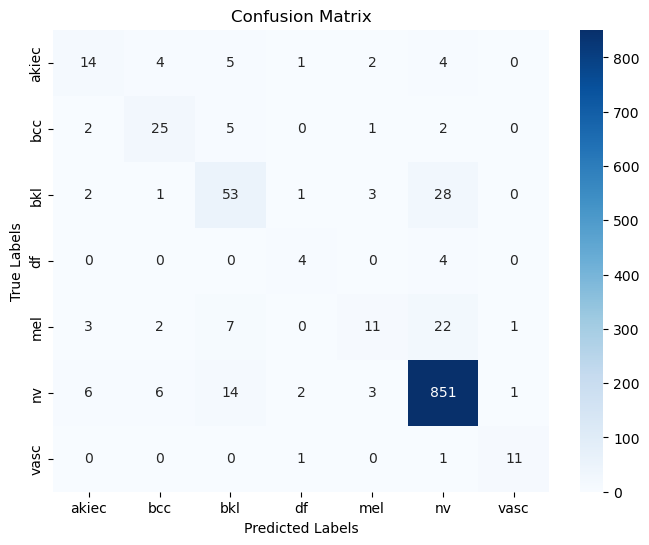

Accuracy on the evaluation dataset: 87.85%


Precision: [0.51851852 0.65789474 0.63095238 0.44444444 0.55       0.93311404
 0.84615385]
Recall: [0.46666667 0.71428571 0.60227273 0.5        0.23913043 0.96375991
 0.84615385]
F1 Score: [0.49122807 0.68493151 0.61627907 0.47058824 0.33333333 0.94818942
 0.84615385]


In [ ]:
evaluate_model(inceptionNetBP)

In [ ]:
torch.save(inceptionNetBP.state_dict(), './models/inceptionNetBP_20ep.pth')
trainer.close()

In [48]:
inceptionNetWOBP = InceptionNetV3(num_classes=7)
_, optimizer = requirementsForModelTraining(inceptionNetWOBP)
trainer = composer.Trainer(
    model=inceptionNetWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='15ep',
    loggers=logger
)


start_time = time.perf_counter()
trainer.fit()
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")


******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 2899244715

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 8441.1507 seconds to train


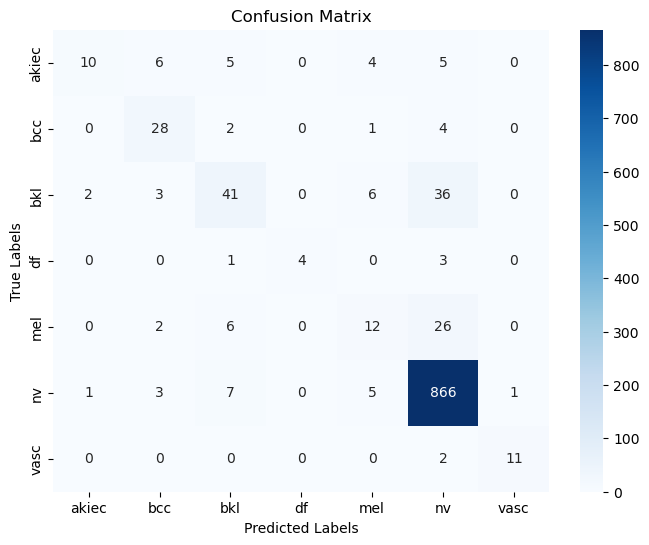

Accuracy on the evaluation dataset: 88.12%


Precision: [0.76923077 0.66666667 0.66129032 1.         0.42857143 0.91932059
 0.91666667]
Recall: [0.33333333 0.8        0.46590909 0.5        0.26086957 0.98074745
 0.84615385]
F1 Score: [0.46511628 0.72727273 0.54666667 0.66666667 0.32432432 0.9490411
 0.88      ]


In [49]:
evaluate_model(inceptionModelWOBP)

In [ ]:
torch.save(inceptionNetWOBP.state_dict(), './models/inceptionNetWOBP_20ep.pth')
trainer.close()

# DenseNet


In [46]:


class DenseNet161(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.densenet161()  # Use DenseNet-161
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

        self.num_classes = num_classes
        self.num_classes = num_classes
        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is None:
            outputs = self.forward(inputs)
        return outputs

    def update_metric(self, batch, outputs, metric):
        _, targets = batch
        # Calculate class predictions from the model outputs
        preds = torch.argmax(outputs, dim=1)
        # Ensure predictions have shape (N, ...)
        preds = preds.view(-1)
        # Ensure targets have shape (N, ...)
        targets = targets.view(-1)
        metric.update(preds, targets)
        
    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [51]:
denseNetBP = DenseNet161(num_classes=7)
algorithms, optimizer = requirementsForModelTraining(denseNetBP)
trainer = Trainer(
    model=denseNetBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 0
blurpool/num_blurpool_layers: 1
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 1343909343

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 10389.9995 seconds to train


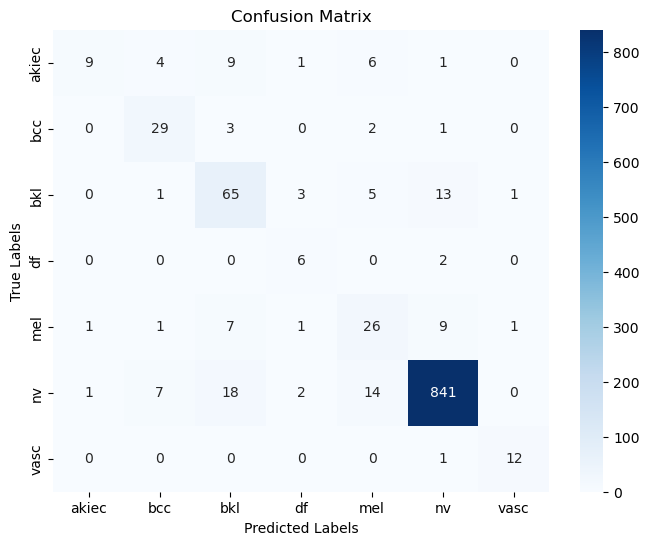

Accuracy on the evaluation dataset: 89.57%


Precision: [0.81818182 0.69047619 0.6372549  0.46153846 0.49056604 0.96889401
 0.85714286]
Recall: [0.3        0.82857143 0.73863636 0.75       0.56521739 0.95243488
 0.92307692]
F1 Score: [0.43902439 0.75324675 0.68421053 0.57142857 0.52525253 0.96059395
 0.88888889]


In [52]:
evaluate_model(denseNetModel)

In [ ]:
torch.save(denseNetBP.state_dict(), './models/denseNetBP_20ep.pth')
trainer.close()

In [47]:
denseNetWOBP = DenseNet161(num_classes=7)
_, optimizer = requirementsForModelTraining(denseNetWOBP)
trainer = Trainer(
    model=denseNetWOBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    loggers=logger
)

start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3026130946

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 10543.2514 seconds to train


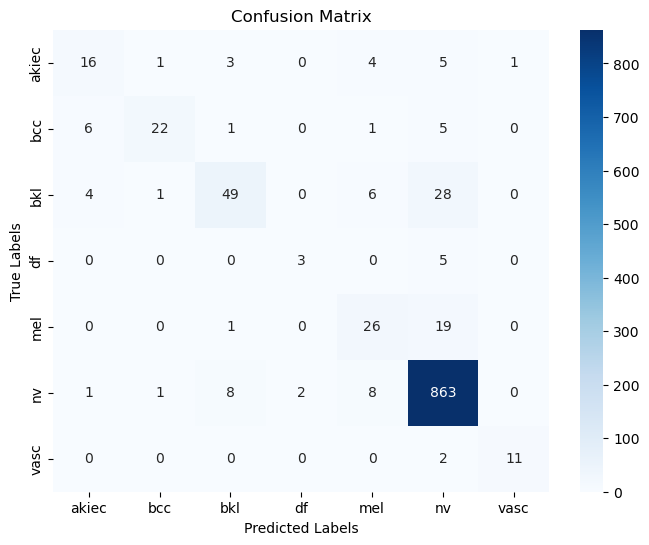

Accuracy on the evaluation dataset: 89.76%


Precision: [0.59259259 0.88       0.79032258 0.6        0.57777778 0.93096009
 0.91666667]
Recall: [0.53333333 0.62857143 0.55681818 0.375      0.56521739 0.97734994
 0.84615385]
F1 Score: [0.56140351 0.73333333 0.65333333 0.46153846 0.57142857 0.95359116
 0.88      ]


In [49]:
evaluate_model(denseNetWOBP)

In [ ]:
torch.save(denseNetWOBP.state_dict(), './models/denseNetWOBP_20ep.pth')
trainer.close()

In [45]:
class ResNet18WeightsNone(ComposerModel):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=None)

    def forward(self, batch):  # batch is the output of the dataloader
        # Determine the format of the batch and handle it accordingly
        if isinstance(batch, tuple):
            # If the batch is in the format (inputs, targets)
            inputs, targets = batch
        else:
            # If the batch is just the inputs
            inputs = batch

        return self.model(inputs)

    def loss(self, outputs, batch):
        # pass batches and `forward` outputs to the loss
        _, targets = batch
        return F.cross_entropy(outputs, targets)

In [46]:
resnet18WN = ResNet18WeightsNone()
algorithms, optimizer=requirementsForModelTraining(resnet18WN)
trainer = Trainer(
    model=resnet18WN,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [ ]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

In [ ]:
evaluate_model(resnet18WN)

In [ ]:
torch.save(resnet18WN.state_dict(), './models/resnet18WN_20ep.pth')
trainer.close()

# Custom Models


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomeModel143K(composer.models.ComposerClassifier):
    def __init__(self, num_classes: int):
        super(SimpleModel, self).__init__(
            nn.Sequential(
                ################################## 1 ST CONVOLUTIONAL BLOCK #####################################  
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(16),
                nn.Dropout(0.06),
                nn.MaxPool2d(2, 2),  # in 128, out 128

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Dropout(0.07),
                nn.MaxPool2d(2, 2),  # in 64, out 64

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.Dropout(0.07),
                nn.MaxPool2d(2, 2),  # in 32, out 32

                nn.Conv2d(in_channels=64, out_channels=120, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(120),

                nn.AvgPool2d(kernel_size=32),  # 1x1/128
                nn.Flatten(),
                nn.Linear(120, num_classes)  # Output layer with 7 classes
            ),
            num_classes=num_classes
        )


num_classes = 7  # Number of classes in dataset
my_model = SimpleModel(num_classes=num_classes).to('cuda')

input_size = (1, 3, 256, 256)  # Batch size, channels, height, width
summary(my_model, input_size=input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
       BatchNorm2d-3         [-1, 16, 256, 256]              32
            Conv2d-4         [-1, 16, 256, 256]           2,320
              ReLU-5         [-1, 16, 256, 256]               0
       BatchNorm2d-6         [-1, 16, 256, 256]              32
           Dropout-7         [-1, 16, 256, 256]               0
         MaxPool2d-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
             ReLU-10         [-1, 32, 128, 128]               0
      BatchNorm2d-11         [-1, 32, 128, 128]              64
           Conv2d-12         [-1, 32, 128, 128]           9,248
             ReLU-13         [-1, 32, 128, 128]               0
      BatchNorm2d-14         [-1, 32, 1

In [46]:
customModel143K = CustomeModel143K(num_classes=7)
algorithms, optimizer=requirementsForModelTraining(customModel143K)
logger = InMemoryLogger()
trainer = Trainer(
    model=customModel143K,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    loggers=logger
)

In [47]:
start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3249327425

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  15:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  15:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  16:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  16:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  17:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  17:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  18:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  18:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  19:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  19:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 5801.4058 seconds to train


In [ ]:
evaluate_model(customModel143k)

In [ ]:
torch.save(customModel143k.state_dict(), './models/customModel143k_20ep.pth')
trainer.close()

In [52]:
customModel143kBP = SimpleModel(num_classes=7)
algorithms, optimizer=requirementsForModelTraining(customModel143kBP)
logger = InMemoryLogger()
trainer = Trainer(
    model=customModel143kBP,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [53]:
start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 0
blurpool/num_blurpool_layers: 3
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 588916832

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  15:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  15:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  16:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  16:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  17:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  17:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  18:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  18:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  19:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  19:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 5435.4563 seconds to train


In [ ]:
evaluate_model(customModel143kBP)


In [ ]:
torch.save(customModel143kBP.state_dict(), './models/customModel143kBP_20ep.pth')
trainer.close()

In [43]:
class EfficientNetB3Weights(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.efficientnet_b3(weights=None)
        
        # Modify the final classification head
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = torch.nn.Linear(in_features, num_classes)
        
        self.num_classes = num_classes
        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        # Print the number of classes attribute
        metric.update(outputs, targets)
        
    def _eval_train_metrics(self, device_batch):
            # Separate inputs and targets from the device_batch
            inputs, targets = device_batch

            # Set the model to evaluation mode
            self.model.eval()

            # Perform the forward pass and get the outputs
            with torch.no_grad():
                outputs = self.model(inputs)
                eval_outputs = self.eval_forward(device_batch, outputs)

            # Update the metrics with the computed outputs
            for _, metric in self.state.train_metrics.items():
                self.update_metric(device_batch, eval_outputs, metric)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [44]:
efficientModelWeightsNone = EfficientNetB3Weights(num_classes=7)
algorithms, optimizer,  = requirementsForModelTraining(efficientModelWeightsNone)
trainer = Trainer(
    model=efficientModelWeightsNone,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

In [45]:
start_time = time.perf_counter()
trainer.fit()  # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
blurpool/num_blurconv_layers: 4
blurpool/num_blurpool_layers: 0
enabled_algorithms/BlurPool: true
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 202643354

******************************


train          Epoch   0:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   0:    0%|| 0/111 [00:00<?, ?ba/s]         

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/composer/core/data_spec.py:35: UserWarning: Cannot split tensor of length 3 into batches of size 10. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   3:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   3:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   4:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   4:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   5:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   5:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   6:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   6:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   7:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   7:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   8:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   8:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch   9:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch   9:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  10:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  10:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  11:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  11:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  12:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  12:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  13:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  13:    0%|| 0/111 [00:00<?, ?ba/s]         

train          Epoch  14:    0%|| 0/3889 [00:00<?, ?ba/s]         

eval           Epoch  14:    0%|| 0/111 [00:00<?, ?ba/s]         

It took 10442.3572 seconds to train


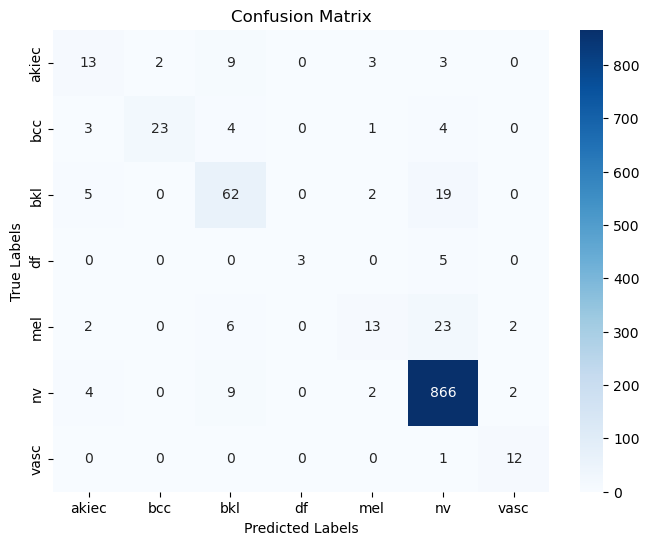

Accuracy on the evaluation dataset: 89.94%


Precision: [0.48148148 0.92       0.68888889 1.         0.61904762 0.9402823
 0.75      ]
Recall: [0.43333333 0.65714286 0.70454545 0.375      0.2826087  0.98074745
 0.92307692]
F1 Score: [0.45614035 0.76666667 0.69662921 0.54545455 0.3880597  0.96008869
 0.82758621]


In [47]:
evaluate_model(efficientModelWeightsNone)

In [42]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
from composer.models import ComposerModel

class MobileNet(ComposerModel):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.mobilenet_v2(weights=class_weights)  # You can use pretrained weights if needed
        self.num_classes = num_classes

        # Modify the final classification head
        in_features = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(in_features, num_classes)

        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='micro')

    def forward(self, batch):
        if isinstance(batch, tuple):
            inputs, targets = batch
        else:
            inputs = batch
        return self.model(inputs)

    def loss(self, outputs, batch):
        _, targets = batch
        return F.cross_entropy(outputs, targets)

    def eval_forward(self, batch, outputs=None):
        inputs, targets = batch
        if outputs is not None and outputs.numel() > 0:
            if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
                outputs = torch.softmax(outputs, dim=1)
            return outputs
        else:
            return self.forward(inputs)

    def update_metric(self, batch, outputs, metric):
        _, targets = batch

        # Ensure that the outputs tensor has the correct number of classes
        if outputs.dim() > 1 and outputs.shape[1] != self.num_classes:
            outputs = torch.softmax(outputs, dim=1)  # Apply softmax if necessary

        metric.update(outputs, targets)

    def get_metrics(self, is_train=False):
        return {'MulticlassAccuracy': self.train_accuracy} if is_train else {'MulticlassAccuracy': self.val_accuracy}


In [45]:
mobileNetWithClass = MobileNet(num_classes=7)
algorithms, optimizer,  = requirementsForModelTraining(mobileNetWithClass)
logger = InMemoryLogger()
trainer = Trainer(
    model=mobileNetWithClass,
    optimizers=optimizer,
    train_dataloader=train_dataloader, 
    eval_dataloader=valid_dataloader,
    max_duration='20ep',
    algorithms=algorithms,
    loggers=logger
)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 348MB/s]


In [48]:
mobileNetWithClass.load_state_dict(class_weights)

AttributeError: 'int' object has no attribute 'startswith'